# Classification of Pulsars: Distinguishing between Real and Candidate Pulsars Using Emission Patterns #


## Introduction
<font color=grey>Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.
Clearly state the question you will try to answer with your project.
Identify and describe the dataset that will be used to answer the question. 


Pulsars are a rare type of Neutron star that rotate, releasing focused electromagnetic radiation out into space from its magnetic poles. This radiation can then be detected on Earth in the form of repeating broadband radio emissions as the pulsar rotates. As a result, the method of detecting pulsars is to search for periodic radio signals using large radio telescopes. Since each pulsar has a different radio pattern, then the signal is averaged over several rotations, but oftentimes the radio signals are caused by radio frequency interference. Thus, we are trying to answer the question “Is a particular radio signal indicative of a pulsar or not?”. 

To answer this question, we will be using the HTRU2 Data Set from the UC Irvine Machine Learning Repository, which contains the mean, standard deviation, excess kurtosis, and skewness of both the integrated profile (signal averaged over time and frequency) and DM-SNR curve (quality of an observation as a function of the dispersion measure of a candidate). The dataset also includes a binary classification label, which indicated if the observation is a pulsar (1) or not (0). 

## Preliminary exploratory data analysis
<font color=grey>Demonstrate that the dataset can be read from the web into R

<font color=grey>Clean and wrangle your data into a tidy format

In [1]:
library(tidyverse)    #The required R packages
library(tidymodels)
library(rvest)
set.seed(1)           #Setting the seed

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
temp <- tempfile()
download.file(url,temp)                                            #Loads the zipfile into the tempfile

pulsar_data <- read.table(unz(temp, "HTRU_2.arff"), skip = 11) |>  #Unzips the zipfile and extracts the dataset
               separate(col = "V1",                                #Tidies the data to have the correct number and names of columns
                        into = c("mean", "st_deviation", "excess_kurtosis", "skewness", 
                          "mean_curve", "st_deviation_curve", "excess_kurtosis_curve", "skewness_curve", "class"),
                        sep = ',',
                        convert = TRUE) |>
              mutate(class = as_factor(class))
unlink(temp)                                                       #Deletes the temporary zipfile
head(pulsar_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

,mean,st_deviation,excess_kurtosis,skewness,mean_curve,st_deviation_curve,excess_kurtosis_curve,skewness_curve,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
2,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
3,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
4,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
5,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
6,93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<font color=grey>Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [2]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)

The first table compares the number of rows with respect to the class label. This also includes the total percentage of rows with a certain label in the entire training dataset, as well as the number of rows that have missing data.

In [3]:
pulsar_proportions <- pulsar_train |>
                     group_by(class) |>
                     summarize(number_of_rows = n()) |>
                     mutate(percent = 100*number_of_rows/nrow(pulsar_train)) |>
                     mutate(na = sum(is.na(pulsar_train)))
pulsar_proportions

class,number_of_rows,percent,na
<fct>,<int>,<dbl>,<int>
0,12200,90.888773,0
1,1223,9.111227,0


The second table computes the means of the predictors in the training set. 

In [4]:
predictor_means <- pulsar_train |>
                   select(mean, st_deviation) |>
                   mutate(mean = mean(mean)) |>
                   mutate(st_deviation = mean(st_deviation)) |>
                   slice(1)
predictor_means

mean,st_deviation
<dbl>,<dbl>
111.1363,46.56378


These two tables are important in showing that the labels must be balanced and that the predictors must be standardized in order for the classifier to be as accurate as possible. As a result, we may require the use of the R package `themis` to balance the class labels.

<font color=grey>Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). 
An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

The following two histograms display the distributions of the mean and standard deviation predictors, respectively. 

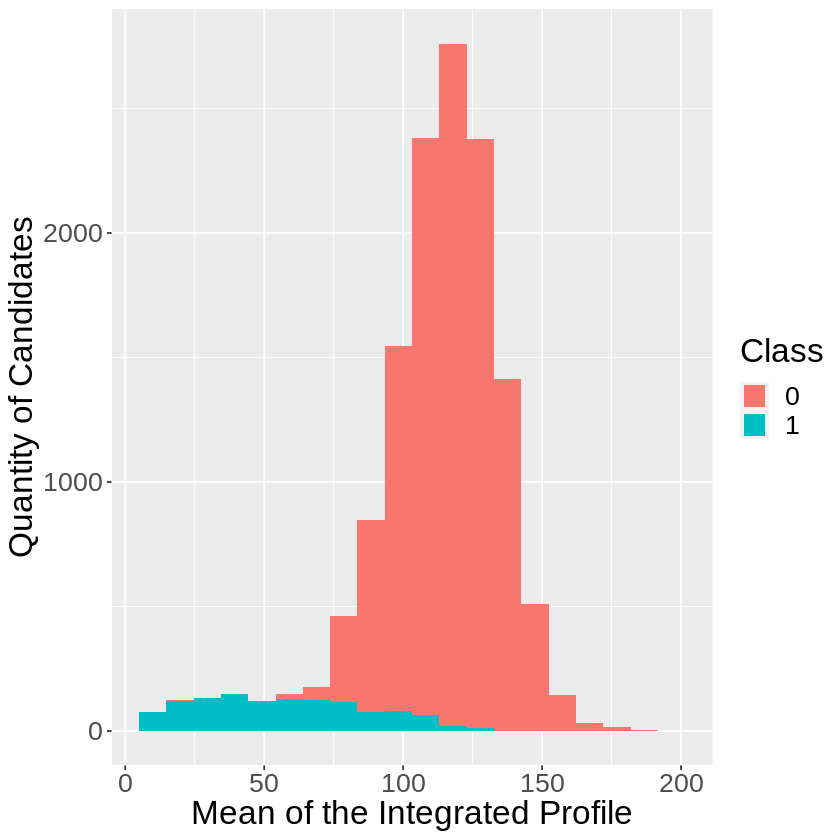

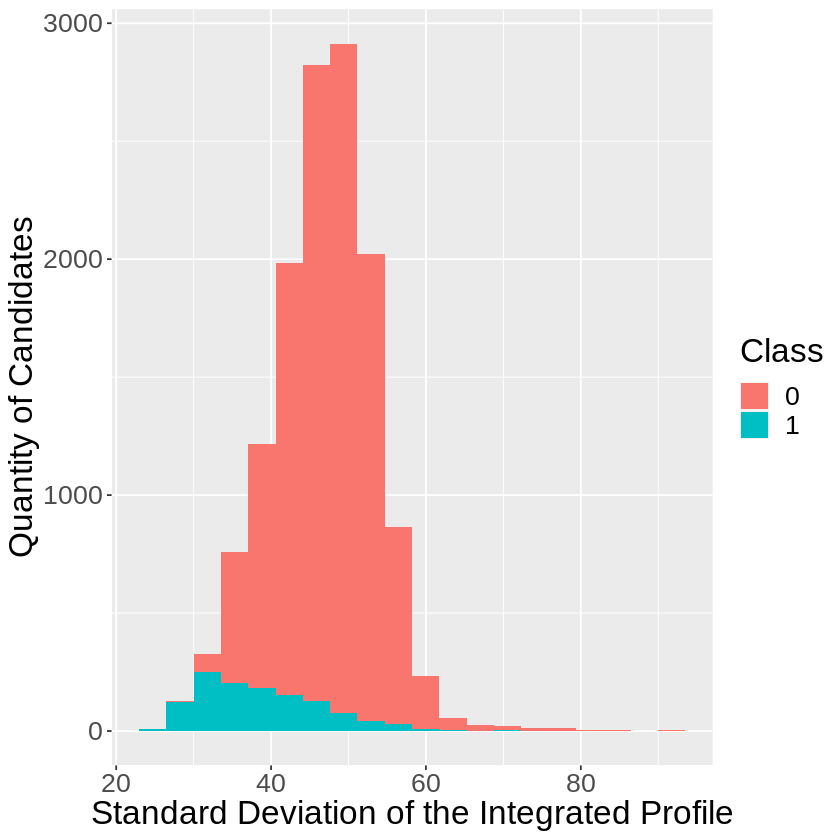

In [5]:
pulsar_mean_hist <- pulsar_train |>
                    ggplot(aes(x = mean, fill = class)) +
                          geom_histogram(bins = 20, size = 1.5) +
                          labs(x = "Mean of the Integrated Profile",
                               y = "Quantity of Candidates",
                               fill = "Class") +
                          theme(text = element_text(size=20))

pulsar_mean_hist

pulsar_st_devi_hist <- pulsar_train |>
                       ggplot(aes(x = st_deviation, fill = class)) +
                              geom_histogram(bins = 20) +
                              labs(x = "Standard Deviation of the Integrated Profile",
                                   y = "Quantity of Candidates",
                                   fill = "Class") +
                              theme(text = element_text(size=20))

pulsar_st_devi_hist

From the graphs, it is evident that the true pulsars are fewer in number, and are most encountered in a specific range. The non-pulsars are greater in number and have a wider range of values. With that in mind, we can visualize how a scatterplot of standard deviation over mean of the integrated profile may look like. To mitigate overplotting, the points were made to be nearly transparent.

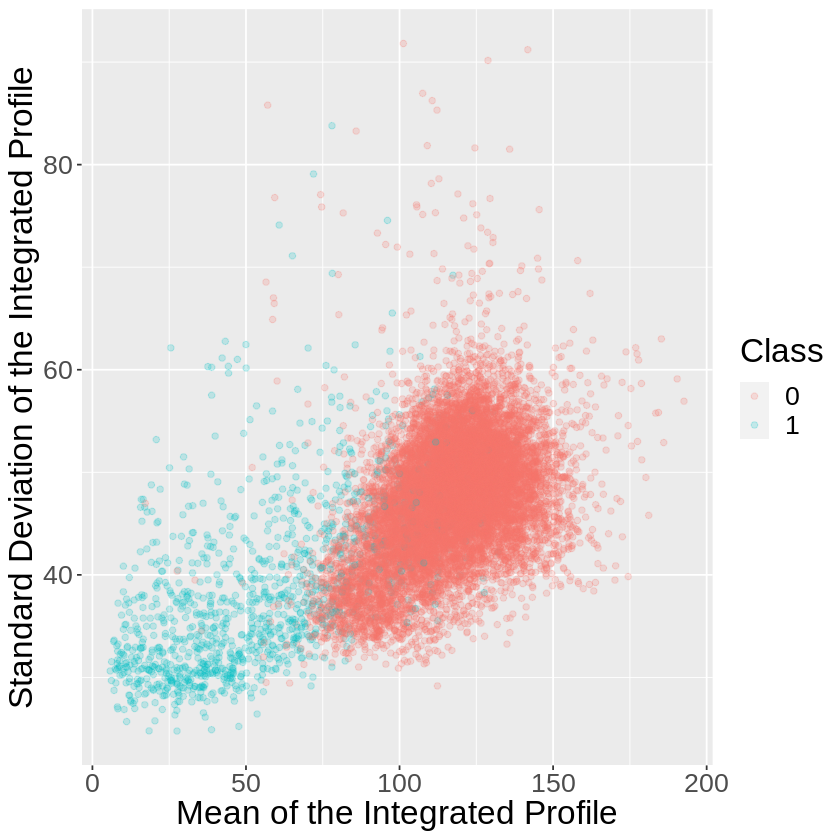

In [6]:
mean_v_st_deviation_plot <- pulsar_train |>
                            ggplot(aes(x = mean, y = st_deviation)) +
                                geom_point(aes(color = class), alpha = 0.2) +
                                xlab("Mean of the Integrated Profile") +
                                ylab("Standard Deviation of the Integrated Profile") +
                                labs(color = "Class") +
                                theme(text = element_text(size=20))
mean_v_st_deviation_plot

## Methods
<font color=grey>Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

<font color=grey>Describe at least one way that you will visualize the results


We will be using the **K**-nearest neighbors algorithm to predict the class of an observation, with the mean and standard deviation of the integrated profile as predictors. We are using these predictors since we want to see if we can correctly identify pulsars using the averaged signal over time and frequency of radio emissions, along with its standard deviation. 

One way we can visualize the accuracy of our classifier is to create a bar chart that shows the percentage of correct predictions and incorrect predictions, further subdivided into false positives and false negatives. 

## Expected outcomes and significance

<font color=grey>What do you expect to find?

We expect to find a quick, nonstrenuous, and reliable way to classify candidacy of a pulsar based on the radio emissions averages over time and frequency, as well as its standard deviation. 

<font color=grey>What impact could such findings have?

The impact of these findings could be to classify pulsars easier, as well as determining the likelihood if a radio frequency is the result of a pulsar’s electromagnetic radiation. This could also reduce the strenuous workload of astrophysicists, who would not need to spend as much time identifying pulsars for study.

<font color=grey>What future questions could this lead to?

This could lead to further questions of how to classify other neutron stars using emissions, including magnetars. Could this classification model be expanded to classify other stars? With systemic and automatic classification of pulsars, would it be possible to find the pulsar population of a region or galaxy? Potentially, there may also be a way of identifying if a star is reaching its end based on its emissions.

## Sources Cited

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

R. J. Lyon, 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016.